---
title: "Compare averages 1"
author: "Laura Vairus"
date: "2023-07-14"
---

## Import Libraries

In [1]:
import tensorflow as tf
# Make sure the GPU is enabled 
assert tf.config.list_physical_devices('GPU'), 'Start the colab kernel with GPU: Runtime -> Change runtime type -> GPU'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import tensorflow_hub as hub # for interacting with saved models and tensorflow hub
import joblib
import gzip # for manipulating compressed files
import kipoiseq # for manipulating fasta files
from kipoiseq import Interval # same as above, really
import pyfaidx # to index our reference genome file
import pandas as pd # for manipulating dataframes
import numpy as np # for numerical computations
import matplotlib.pyplot as plt # for plotting
import matplotlib as mpl # for plotting
import seaborn as sns # for plotting
import pickle # for saving large objects
import os, sys # functions for interacting with the operating system

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

2023-07-17 19:17:14.481091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  4


## Define Paths

In [2]:
transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = '/grand/TFXcan/imlab/users/lvairus/hackenf/data/genome.fa'
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')

## Define Functions

In [3]:
# @title `Enformer`, `EnformerScoreVariantsNormalized`, `EnformerScoreVariantsPCANormalized`,
SEQUENCE_LENGTH = 393216

class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)


class EnformerScoreVariantsRaw:

  def __init__(self, tfhub_url, organism='human'):
    self._model = Enformer(tfhub_url)
    self._organism = organism

  def predict_on_batch(self, inputs):
    ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
    alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

    return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)


class EnformerScoreVariantsNormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      transform_pipeline = joblib.load(f)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)


class EnformerScoreVariantsPCANormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      self._transform = joblib.load(f)
    self._num_top_features = num_top_features

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]


# TODO(avsec): Add feature description: Either PCX, or full names.


# @title `variant_centered_sequences`

class FastaStringExtractor:

    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}
    #import pd.Interval as Interval
    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()


def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)



# @title `plot_tracks`

def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

In [4]:
import Bio

from Bio.Seq import Seq
def create_rev_complement(dna_string):
    return(str(Seq(dna_string).reverse_complement()))

In [5]:
def prepare_for_quantify_prediction_per_TSS(predictions, gene, tss_df):

  '''

  Parameters:
          predicitions (A numpy array): All predictions from the track
          gene (a gene name, character): a gene
          tss_df: a list of dataframe of genes and their transcription start sites
  Returns:
          A dictionary of cage experiment predictions and a list of transcription start sites

  '''

  output = dict()
  for tdf in tss_df:
    if gene not in tdf.genes.values:
      continue
    gene_tss_list = tdf[tdf.genes == gene].txStart_Sites.apply(str).values
    gene_tss_list = [t.split(', ') for t in gene_tss_list]
    gene_tss_list = [int(item) for nestedlist in gene_tss_list for item in nestedlist]
    gene_tss_list = list(set(gene_tss_list))
  output['cage_predictions'] = predictions[:, 5110] # a numpy array
  output['gene_TSS'] = gene_tss_list # a list


  return(output) # a dictionary

def quantify_prediction_per_TSS(low_range, TSS, cage_predictions):

  '''
  Parameters:
          low_range (int): The lower interval
          TSS (list of integers): A list of TSS for a gene
          cage_predictions: A 1D numpy array or a vector of predictions from enformer corresponding to track 5110 or CAGE predictions
  Returns:
          A dictionary of gene expression predictions for each TSS for a gene
    '''
  tss_predictions = dict()
  for tss in TSS:
    bin_start = low_range + ((768 + 320) * 128)
    count = -1
    while bin_start < tss:
      bin_start = bin_start + 128
      count += 1
    if count >= len(cage_predictions)-1:
      continue
    cage_preds = cage_predictions[count - 1] + cage_predictions[count] + cage_predictions[count + 1]
    tss_predictions[tss] = cage_preds

  return(tss_predictions)

def collect_intervals(chromosomes = ["22"], gene_list=None):

  '''
    Parameters :
      chromosomes : a list of chromosome numbers; each element should be a string format
      gene_list : a list of genes; the genes should be located on those chromosomes

    Returns :
      A dictionary of genes (from gene_list) and their intervals within their respective chromosomes
  '''

  gene_intervals = {} # Collect intervals for our genes of interest

  for chrom in chromosomes:
    with open("/grand/TFXcan/imlab/users/lvairus/hackenf/data/gene_chroms/gene_"+ chrom + ".txt", "r") as chrom_genes:
      for line in chrom_genes:
        split_line = line.strip().split("\t")
        gene_intervals[split_line[2]] = [
                                          split_line[0],
                                          int(split_line[3]),
                                          int(split_line[4])
                                        ]

  if isinstance(gene_list, list): # if the user has supplied a list of genes they are interested in
    use_genes = dict((k, gene_intervals[k]) for k in gene_list if k in gene_intervals)
    return(use_genes)
  elif isinstance(gene_list, type(None)):
    return(gene_intervals)


def run_predictions(gene_intervals, tss_dataframe, individuals_list=None):
  '''
  Parameters :
    gene_intervals : the results from calling `collect_intervals`
    tss_dataframe : a list of the TSSs dataframes i.e. the TSS for the genes in the chromosomes
    individuals_list : a list of individuals on which we want to make predictions; defaults to None

  Returns :
    A list of predictions; the first element is the predictions around the TSS for each gene. The second is the prediction across CAGE tracks
  '''

  gene_output = dict()
  gene_predictions = dict()

  for gene in gene_intervals.keys():
    gene_interval = gene_intervals[gene]
    target_interval = kipoiseq.Interval("chr" + gene_interval[0],
                                        gene_interval[1],
                                        gene_interval[2]) # creates an interval to select the right sequences
    target_fa = fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH))  # extracts the fasta sequences, and resizes such that it is compatible with the sequence_length
    window_coords = target_interval.resize(SEQUENCE_LENGTH) # we also need information about the start and end locations after resizing
    try:
      cur_gene_vars = pd.read_csv("/grand/TFXcan/imlab/users/lvairus/hackenf/data/individual_beds/chr" + gene_interval[0] + "/chr" + gene_interval[0] + "_"+ gene + ".bed", sep="\t", header=0) # read in the appropriate bed file for the gene
    except:
      continue
    individual_results = dict()
    individual_prediction = dict()

    if isinstance(individuals_list, list) or isinstance(individuals_list, type(np.empty([1, 1]))):
      use_individuals = individuals_list
    elif isinstance(individuals_list, type(None)):
      use_individuals = cur_gene_vars.columns[4:]

    for individual in use_individuals:
      print('Currently on gene {}, and predicting on individual {}...'.format(gene, individual))
      # two haplotypes per individual
      haplo_1 = list(target_fa[:])
      haplo_2 = list(target_fa[:])

      ref_mismatch_count = 0
      for i,row in cur_gene_vars.iterrows():

        geno = row[individual].split("|")
        if (row["POS"]-window_coords.start-1) >= len(haplo_2):
          continue
        if (row["POS"]-window_coords.start-1) < 0:
          continue
        if geno[0] == "1":
          haplo_1[row["POS"]-window_coords.start-1] = row["ALT"]
        if geno[1] == "1":
          haplo_2[row["POS"]-window_coords.start-1] = row["ALT"]

      # predict on the individual's two haplotypes
      prediction_1 = model.predict_on_batch(one_hot_encode("".join(haplo_1))[np.newaxis])['human'][0]
      prediction_2 = model.predict_on_batch(one_hot_encode("".join(haplo_2))[np.newaxis])['human'][0]

      temp_predictions = [prediction_1[:, 5110], prediction_2[:, 5110]] # CAGE predictions we are interested in
      individual_prediction[individual] = temp_predictions

      # Calculate TSS CAGE expression which correspond to column 5110 of the predictions above
      temp_list = list()

      pred_prepared_1 = prepare_for_quantify_prediction_per_TSS(predictions=prediction_1, gene=gene, tss_df=tss_dataframe)
      tss_predictions_1 = quantify_prediction_per_TSS(low_range = window_coords.start, TSS=pred_prepared_1['gene_TSS'], cage_predictions=pred_prepared_1['cage_predictions'])

      pred_prepared_2 = prepare_for_quantify_prediction_per_TSS(predictions=prediction_2, gene=gene, tss_df=tss_dataframe)
      tss_predictions_2 = quantify_prediction_per_TSS(low_range = window_coords.start, TSS=pred_prepared_2['gene_TSS'], cage_predictions=pred_prepared_2['cage_predictions'])

      temp_list.append(tss_predictions_1)
      temp_list.append(tss_predictions_2) # results here are a dictionary for each TSS for each haplotype

      individual_results[individual] = temp_list # save for the individual

    gene_output[gene] = individual_results
    gene_predictions[gene] = individual_prediction

  return([gene_output, gene_predictions])


def collect_target_intervals(gene_intervals):

  '''
  Returns a dictionary of Interval objects (from kipoiseq) for each gene corresponding to the locations of the gene
  '''

  target_intervals_dict = dict()

  for gene in gene_intervals.keys():
    gene_interval = gene_intervals[gene]
    target_interval = kipoiseq.Interval("chr" + gene_interval[0],
                                        gene_interval[1],
                                        gene_interval[2])
    target_intervals_dict[gene] = target_interval

  return(target_intervals_dict)

def prepare_for_plot_tracks(gene, individual, all_predictions, chromosome=['22']):

  '''
  This returns a dictionary of gene tracks and gene intervals, prepared for the function plot_tracks.

  Parameters:
    - gene
    - individual
    - all_predictions
  '''

  haplo_predictions = all_predictions[gene][individual]
  gene_tracks = {gene + ' | ' + individual + ' | haplotype 1': np.log10(1 + haplo_predictions[0]),
                gene + ' | ' + individual + ' | haplotype 2': np.log10(1 + haplo_predictions[1])}

  gene_intervals = collect_intervals(chromosomes=chromosome, gene_list=[gene])
  gene_intervals = collect_target_intervals(gene_intervals)

  output = dict()
  output['gene_tracks'] = gene_tracks
  output['gene_intervals'] = gene_intervals[gene]

  return(output)

def check_individuals(path_to_bed_file, list_of_individuals):

  '''
  Checks if an individual is missing in bed variation files.
  These individuals should be removed prior to training
  '''

  myfile = open(path_to_bed_file, 'r')
  myline = myfile.readline()
  bed_names = myline.split('\t')[4:]
  myfile.close()

  if set(list_of_individuals).issubset(set(bed_names)) == False:
    missing = list(set(list_of_individuals).difference(bed_names))
    print('This (or these) individual(s) is/are not present: {}'.format(missing))
  else:
    missing = []
    print('All individuals are present in the bed file.')

  return(missing)

In [6]:
def geno_to_seq(gene, individual):
      # two haplotypes per individual
  haplo_1 = list(target_fa[:])
  haplo_2 = list(target_fa[:])

  ref_mismatch_count = 0
  for i,row in cur_gene_vars.iterrows():

    geno = row[individual].split("|")
    if (row["POS"]-window_coords.start-1) >= len(haplo_2):
      continue
    if (row["POS"]-window_coords.start-1) < 0:
      continue
    if geno[0] == "1":
      haplo_1[row["POS"]-window_coords.start-1] = row["ALT"]
    if geno[1] == "1":
      haplo_2[row["POS"]-window_coords.start-1] = row["ALT"]
  return haplo_1, haplo_2

      # predict on the individual's two haplotypes
    

In [7]:
def run_predictions2(gene, chrom, indiv):
    '''
    Parameters :
       gene: gene to run (string)
       chrom: chrom gene is on (string)
       indiv: individual to run (string)
       chrNtss: variable of tss for chr
    Returns :
        A list of predictions; the first element is the predictions around the TSS for each gene. The second is the prediction across CAGE tracks
    '''
    
    gene_intervals = collect_intervals(chromosomes=[chrom], gene_list=[gene])
    individuals_list = [indiv]

    for gene in gene_intervals.keys():
        global fasta_extractor
        gene_interval = gene_intervals[gene]
        target_interval = kipoiseq.Interval("chr" + gene_interval[0],
                                            gene_interval[1],
                                            gene_interval[2]) # creates an interval to select the right sequences
        target_fa = fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH))  # extracts the fasta sequences, and resizes such that it is compatible with the sequence_length
        window_coords = target_interval.resize(SEQUENCE_LENGTH) # we also need information about the start and end locations after resizing
        try:
            cur_gene_vars = pd.read_csv("/grand/TFXcan/imlab/users/lvairus/hackenf/data/individual_beds/chr" + gene_interval[0] + "/chr" + gene_interval[0] + "_"+ gene + ".bed", sep="\t", header=0) # read in the appropriate bed file for the gene
        except:
            continue
        individual_prediction = dict()

        if isinstance(individuals_list, list) or isinstance(individuals_list, type(np.empty([1, 1]))):
            use_individuals = individuals_list
        elif isinstance(individuals_list, type(None)):
            use_individuals = cur_gene_vars.columns[4:]

        for individual in use_individuals:
            # two haplotypes per individual
            haplo_1 = list(target_fa[:])
            haplo_2 = list(target_fa[:])

            ref_mismatch_count = 0
            for i,row in cur_gene_vars.iterrows():

                geno = row[individual].split("|")
                if (row["POS"]-window_coords.start-1) >= len(haplo_2):
                    continue
                if (row["POS"]-window_coords.start-1) < 0:
                    continue
                if geno[0] == "1":
                    haplo_1[row["POS"]-window_coords.start-1] = row["ALT"]
                if geno[1] == "1":
                    haplo_2[row["POS"]-window_coords.start-1] = row["ALT"]

            # predict on the individual's two haplotypes
            global model

            ohe_haplo_1 = one_hot_encode("".join(haplo_1))[np.newaxis]
            ohe_haplo_2 = one_hot_encode("".join(haplo_2))[np.newaxis]

            ohe_haplo_avg = np.add(ohe_haplo_1, ohe_haplo_2) / 2
                                         
            prediction_1 = model.predict_on_batch(ohe_haplo_1)['human'][0]
            prediction_2 = model.predict_on_batch(ohe_haplo_2)['human'][0]
            prediction_avg = model.predict_on_batch(ohe_haplo_avg)['human'][0]
            
            post_avg = (prediction_1 + prediction_2) / 2
            pre_avg = prediction_avg

    return([pre_avg, post_avg])

In [8]:
def get_summary(arr):
    stats = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "std_dev": np.std(arr),
        "minimum": np.min(arr),
        "maximum": np.max(arr),
        "total_sum": np.sum(arr),
        "q1": np.percentile(arr, 25),
        "q2": np.percentile(arr, 50),
        "q3": np.percentile(arr, 75),
        "iqr": np.percentile(arr, 75) - np.percentile(arr, 25)
    }
    return stats

def make_hist(arr, bin_num):
    plt.hist(arr, bins=bin_num)

    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Display the plot
    plt.show()

In [9]:
def get_relmax(arr):
    col_max = np.max(arr, axis=0)
    relmax = arr / col_max
    return relmax


In [10]:
def get_relmed(arr):
    col_med = np.median(arr, axis=0)
    relmed = arr / col_med
    return relmed

In [11]:
class My_class:
    def __init__(self, gene, chrom, indiv):
        # save starting variables
        self.gene = gene
        self.chrom = chrom
        self.indiv = indiv
        # run predictions
        self.pre_avg, self.post_avg = run_predictions2(gene, chrom, indiv)
        # get difference matrices
        self.diffmat = self.pre_avg - self.post_avg
        self.abs_diffmat = abs(self.diffmat) # check this
        self.rel_diffmat = self.abs_diffmat / (abs(self.pre_avg) + abs(self.post_avg) + 1**-16) * 100
        self.relmax_diffmat = get_relmax(self.abs_diffmat)
        self.relmed_diffmat = get_relmed(self.abs_diffmat)
    
    def get_diffmats(self):
        return [self.abs_diffmat, self.rel_diffmat, self.relmax_diffmat, self.relmed_diffmat]

    def get_summary(self, arr):
        stats = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "std_dev": np.std(arr),
        "minimum": np.min(arr),
        "maximum": np.max(arr),
        "total_sum": np.sum(arr),
        "q1": np.percentile(arr, 25),
        "q2": np.percentile(arr, 50),
        "q3": np.percentile(arr, 75),
        "iqr": np.percentile(arr, 75) - np.percentile(arr, 25)
        }
        return stats
    
    def get_outliers(self, arr, tol):
        outliers = arr[arr>tol]
        return outliers
    
    def make_hist(self, arr, bin_num):
        plt.hist(arr, bins=bin_num)
        # Add labels and title
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        # Display the plot
        plt.show()
        return None
    
    def get_outlier_inds(self, arr, tol):
        # get inds of outliers list of [row,col] lists
        outlier_inds = np.where(arr > tol)
        outlier_inds_arr = np.array(list(zip(outlier_inds[0], outlier_inds[1])))

        # define outlier row inds
        row_inds = outlier_inds[0]      # all outlier row inds
        
        #define outlier col inds
        col_inds = outlier_inds[1]      # all outlier col inds

        print("to get list of unique inds: set(inds_arr) ")
        print("get count of inds: Counter(inds_arr)")

        return (outlier_inds_arr, row_inds, col_inds)
    
    def make_table(self, arr, tol):
        # input difference arr and tolerance
        # get outliers with tolerance
        outs = arr[arr>tol]
        out_inds = np.where(arr > tol)
        col_inds = out_inds[1]   
        row_inds = out_inds[0]
        # labels for track names from col names
        global track_names
        # row_inds 
        # outlier values 
        data = {
            'track': [track_names[i] for i in col_inds],
            'bin': row_inds,
            'diff': outs
        }
        df = pd.DataFrame(data)
        return df
    
    def plot_tol_numouts(self, arr, mintol, maxtol, steps):
        x = np.linspace(maxtol, mintol, steps)
        y = []
        for tol in x:
            y.append(len(self.get_outliers(arr, tol)))
        # Create scatter plot
        plt.scatter(x, y)
        # Add labels and title
        plt.xlabel('Tolerance')
        plt.ylabel('Amount of Outliers')
        # Display the plot
        plt.show()
        return None



In [12]:
def print_comparisons(pre_average, post_average, tolerance):

    dict = {}
    diffmat = pre_average - post_average

    # abs diff matrix
    abs = {}
    print("Absolute Difference:")

    # make abs diff mat
    abs_mat = np.sqrt(np.square(diffmat))
    abs['mat'] = abs_mat

    # get summary of mat
    abs_mat_summary = get_summary(abs_mat)
    abs['mat_summary'] = abs_mat_summary
    print(f"Summary Statistics: \n{abs_mat_summary}")

    # get outlier differences
    outlier_abs = abs_mat[abs_mat>tolerance]
    abs["outliers"] = outlier_abs
    print(f'num outliers: \n{len(outlier_abs)}')

    # summary of outliers
    outlier_abs_summary = get_summary(outlier_abs)
    abs['outliers-summary'] = outlier_abs_summary
    print(f'Summary of Outliers: \n{outlier_abs_summary}')

    # histogram of outliers 
    print("Histogram of Outliers for Absolute Difference")
    make_hist(outlier_abs, 20)

    # get inds of outliers list of [row,col] lists
    outlier_abs_inds = np.where(abs_mat > tolerance)
    outlier_abs_inds_arr = np.array(list(zip(outlier_abs_inds[0], outlier_abs_inds[1])))
    abs['outlier-inds'] = outlier_abs_inds_arr
    # define outlier row inds
    row_inds = outlier_abs_inds[0]      # all outlier row inds
    row_inds_uq = set(row_inds)         # unique outlier row inds
    row_inds_count = Counter(row_inds)  # counter of outlier row inds
    #define outlier col inds
    col_inds = outlier_abs_inds[1]      # all outlier col inds
    col_inds_uq = set(col_inds)         # unique outlier col inds
    col_inds_count = Counter(col_inds)  # counter of outlier col inds

    #hist of row outlier inds
    print(f'num unique row outlier inds: {len(row_inds_uq)}')
    make_hist(row_inds)

    #hist of col outlier inds



    # rel diff matrix
    #rel_diff = (abs_diff) / ((pre_average + post_average) + 10**-16)


    # rel max diff matrix


    dict["abs"] = abs

    return dict





## Prepare input data

We want to predict epigenome around HINT2 TSS on chromosome 9.

In [13]:
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')

In [14]:
track_names = df_targets['description'].tolist()
track_names

['DNASE:cerebellum male adult (27 years) and male adult (35 years)',
 'DNASE:frontal cortex male adult (27 years) and male adult (35 years)',
 'DNASE:chorion',
 'DNASE:Ishikawa treated with 0.02% dimethyl sulfoxide for 1 hour',
 'DNASE:GM03348',
 'DNASE:GM03348 genetically modified using transduction treated with 3 ug/mL doxycycline for 10 days',
 'DNASE:AG08395',
 'DNASE:AG08396',
 'DNASE:AG20443',
 'DNASE:frontal cortex female adult (67 years) and female adult (80 years)',
 'DNASE:H54',
 'DNASE:GM10248',
 'DNASE:GM12878',
 'DNASE:GM12891',
 'DNASE:GM12892',
 'DNASE:GM18507',
 'DNASE:GM19238',
 'DNASE:GM19239',
 'DNASE:GM19240',
 'DNASE:H1-hESC',
 'DNASE:H7-hESC',
 'DNASE:H9',
 'DNASE:heart male adult (27 years) and male adult (35 years)',
 'DNASE:HEK293T',
 'DNASE:HeLa-S3 treated with interferon alpha for 4 hours',
 'DNASE:HeLa-S3',
 'DNASE:hepatocyte',
 'DNASE:HepG2',
 'DNASE:HTR-8/SVneo',
 'DNASE:endothelial cell of umbilical vein newborn',
 'DNASE:CWRU1 male',
 'DNASE:iPS-NIHi11 m

In [15]:
chrom_bed_downloads = pd.read_csv("https://uchicago.box.com/shared/static/du77wf31li38tciv8imivwu57svae03p.csv")
chrom_bed_downloads.index = chrom_bed_downloads["chroms"]

chrom_bed_downloads.head(10)

,chroms,link
chroms,,
1,1,https://uchicago.box.com/shared/static/9q9n4a0...
2,2,https://uchicago.box.com/shared/static/1tk6a3f...
3,3,https://uchicago.box.com/shared/static/77ldwqq...
4,4,https://uchicago.box.com/shared/static/s0g48al...
5,5,https://uchicago.box.com/shared/static/yafgxb1...
6,6,https://uchicago.box.com/shared/static/9vpxc7z...
7,7,https://uchicago.box.com/shared/static/hkru0gi...
8,8,https://uchicago.box.com/shared/static/ruac33s...
9,9,https://uchicago.box.com/shared/static/dfw6gkj...


In [16]:
chr1_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr17_tss_by_gene.txt', sep='\t')
amigo1_variations = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/individual_beds/chr17/chr17_GSDMB.bed', sep='\t')
geuvadis_gene_expression = pd.read_table('https://uchicago.box.com/shared/static/5vwc7pjw9qmtv7298c4rc7bcuicoyemt.gz', sep='\t',
                                         dtype={'gene_id': str, 'gene_name':str, 'TargetID':str, 'Chr':str})
geuvadis_gene_expression.head(5)


,gene_id,gene_name,TargetID,Chr,Coord,HG00096,HG00097,HG00099,HG00100,HG00101,...,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
0,ENSG00000223972.4,DDX11L1,ENSG00000223972.4,1,11869,0.320818,0.344202,0.354225,0.478064,-0.102815,...,1.008605,0.384489,0.581284,0.513981,0.667449,0.350890,0.186103,-0.037976,0.405439,0.199143
1,ENSG00000227232.3,WASH7P,ENSG00000227232.3,1,29806,33.714457,20.185174,18.095407,24.100871,29.018719,...,30.980194,34.086207,39.678442,29.643513,27.120420,29.121624,31.117198,32.047074,22.798959,23.563874
2,ENSG00000243485.1,MIR1302-11,ENSG00000243485.1,1,29554,0.240408,0.157456,0.218806,0.320878,0.067833,...,0.065940,0.228784,0.140642,0.283905,0.273821,0.286311,0.324060,0.049574,0.255288,0.157440
3,ENSG00000238009.2,RP11-34P13.7,ENSG00000238009.2,1,133566,0.328272,0.327932,0.090064,0.420443,0.220269,...,0.274071,0.384179,0.533693,0.307221,0.307367,0.400278,0.612321,0.666633,0.281138,1.346129
4,ENSG00000239945.1,RP11-34P13.8,ENSG00000239945.1,1,91105,0.332171,-0.032164,0.017323,0.424677,0.214025,...,0.347323,0.346744,0.073580,0.400396,0.470517,0.069749,0.299353,0.090019,0.282554,-0.157170


In [17]:
model = Enformer(model_path) # here we load the model architecture.

fasta_extractor = FastaStringExtractor(fasta_file) # we define a class called fasta_extractor to help us extra raw sequence data

In [18]:
gene_intervals = collect_intervals(chromosomes=['17'], gene_list=['GSDMB'])
print(gene_intervals)


{'GSDMB': ['17', 38060848, 38077313]}


## Run Predictions

We'll pick one individual at random.

In [19]:
# rand_individual = np.random.choice(a=geuvadis_gene_expression.columns[6:-1], replace=False) # individuals we are interested in
rand_individual = 'NA12413'

In [20]:
test = My_class('GSDMB', '17', rand_individual)

In [21]:
diffmats = test.get_diffmats()
abs, rel, relmax, relmed = diffmats
rel

array([[2.68207751e-02, 2.14794427e-02, 1.54860010e-02, ...,
        3.27786431e-03, 4.31587268e-03, 5.99253085e-03],
       [1.52227283e-02, 9.49528441e-03, 1.39587221e-03, ...,
        4.25775489e-03, 6.33378932e-03, 3.99001292e-04],
       [5.20520937e-03, 5.04603982e-03, 1.07796649e-02, ...,
        2.46862252e-03, 5.82935056e-03, 1.01276860e-03],
       ...,
       [1.82648703e-01, 1.20395273e-01, 2.26677638e-02, ...,
        3.71882971e-03, 2.21709910e-04, 3.99682624e-03],
       [7.65870988e-01, 4.11944836e-01, 7.03058019e-03, ...,
        7.04148132e-03, 2.09397208e-02, 2.70997807e-02],
       [4.41073626e-01, 1.37864158e-01, 3.22264820e-01, ...,
        1.49025135e-02, 2.87779793e-03, 4.64532932e-04]], dtype=float32)

In [22]:
test.get_summary(test.rel_diffmat)

{'mean': 0.21557848,
 'median': 0.08500237,
 'std_dev': 0.5238661,
 'minimum': 0.0,
 'maximum': 73.63812,
 'total_sum': 1026250.1,
 'q1': 0.02724431036040187,
 'q2': 0.0850023701786995,
 'q3': 0.21821939945220947,
 'iqr': 0.1909750890918076}

In [23]:
abs_table = test.make_table(abs, 1)
abs_table_sorted = abs_table.sort_values('diff')
abs_table_sorted

,track,bin,diff
789,CHIP:H3K4me1:thymus male child (3 years),533,1.000574
2468,CHIP:H3K4me3:esophagus male adult (34 years),760,1.000663
2393,CHIP:HNRNPLL:K562,760,1.000681
2649,CHIP:H3K4me1:CD14-positive monocyte male adult...,867,1.000864
220,CHIP:CTCF:A549 treated with 100 nM dexamethaso...,134,1.001465
...,...,...,...
1002,CHIP:CTCF:K562,540,7.443279
1070,CHIP:CTCF:K562,540,7.470882
864,CHIP:CTCF:K562,539,8.511012
1674,"CAGE:thymus, adult, pool1",563,10.100098


In [24]:
for mat in diffmats:
    print(test.get_summary(mat))

{'mean': 0.011740582, 'median': 0.002480626, 'std_dev': 0.065571606, 'minimum': 0.0, 'maximum': 10.273163, 'total_sum': 55890.43, 'q1': 0.0005608946084976196, 'q2': 0.002480626106262207, 'q3': 0.007642507553100586, 'iqr': 0.007081612944602966}
{'mean': 0.21557848, 'median': 0.08500237, 'std_dev': 0.5238661, 'minimum': 0.0, 'maximum': 73.63812, 'total_sum': 1026250.1, 'q1': 0.02724431036040187, 'q2': 0.0850023701786995, 'q3': 0.21821939945220947, 'iqr': 0.1909750890918076}
{'mean': 0.03527108, 'median': 0.0074218167, 'std_dev': 0.08494974, 'minimum': 0.0, 'maximum': 1.0, 'total_sum': 167906.14, 'q1': 0.0011184182367287576, 'q2': 0.007421816699206829, 'q3': 0.03162767644971609, 'iqr': 0.030509258212987334}
{'mean': 5.7709837, 'median': 1.0, 'std_dev': 116.90829, 'minimum': 0.0, 'maximum': 36243.305, 'total_sum': 27472468.0, 'q1': 0.38562167435884476, 'q2': 1.0, 'q3': 2.418138027191162, 'iqr': 2.0325163528323174}


In [25]:
len(test.get_outliers(rel, 8))

2285

In [ ]:
values = np.linspace(1, 80, 10)
for v in values:
    print(len(test.get_outliers()))

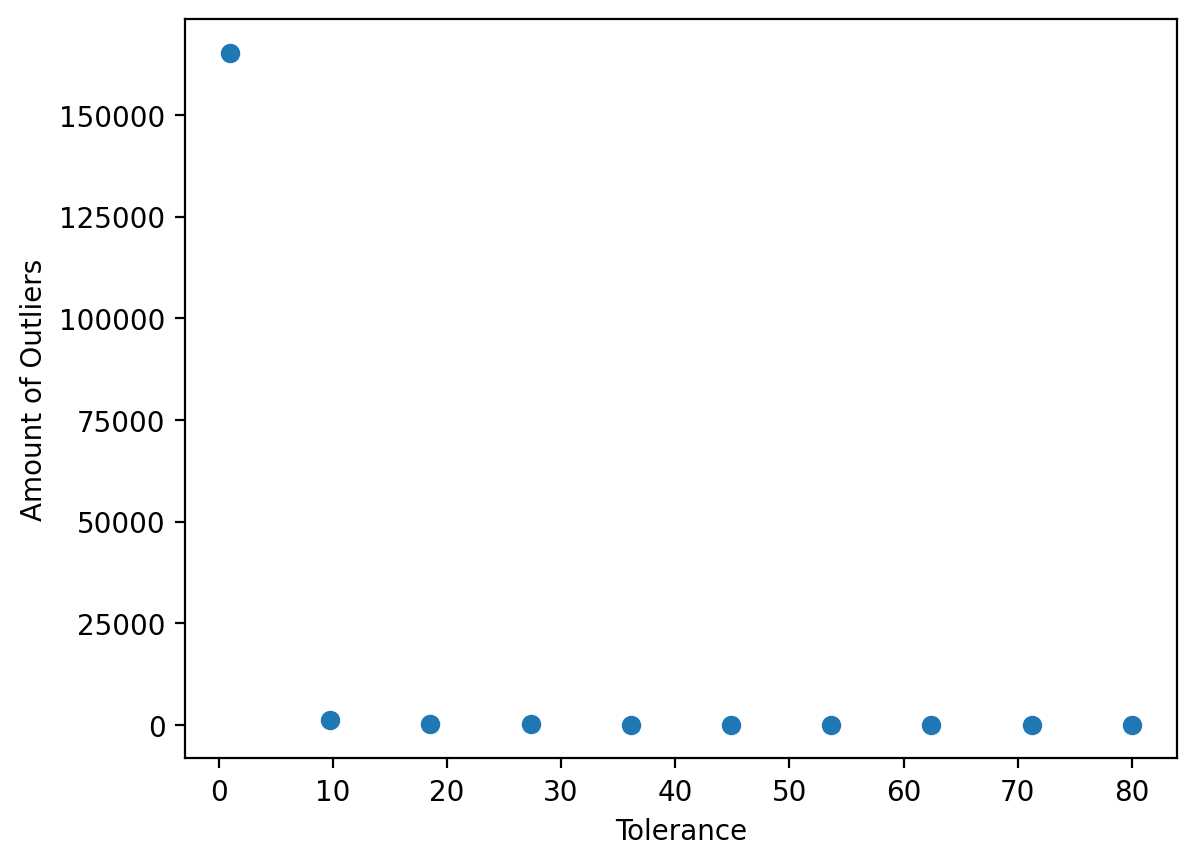

In [26]:
test.plot_tol_numouts(rel, 1, 80, 10)

In [21]:
test_abs_out = test.get_outliers(test.abs_mat, 1)
test.get_outliers(test.abs_mat, 1), len(test.get_outliers(test.abs_mat, 1))

(array([1.0394936, 1.0977535, 1.0580368, ..., 1.274787 , 1.6978073,
        1.5110455], dtype=float32),
 2669)

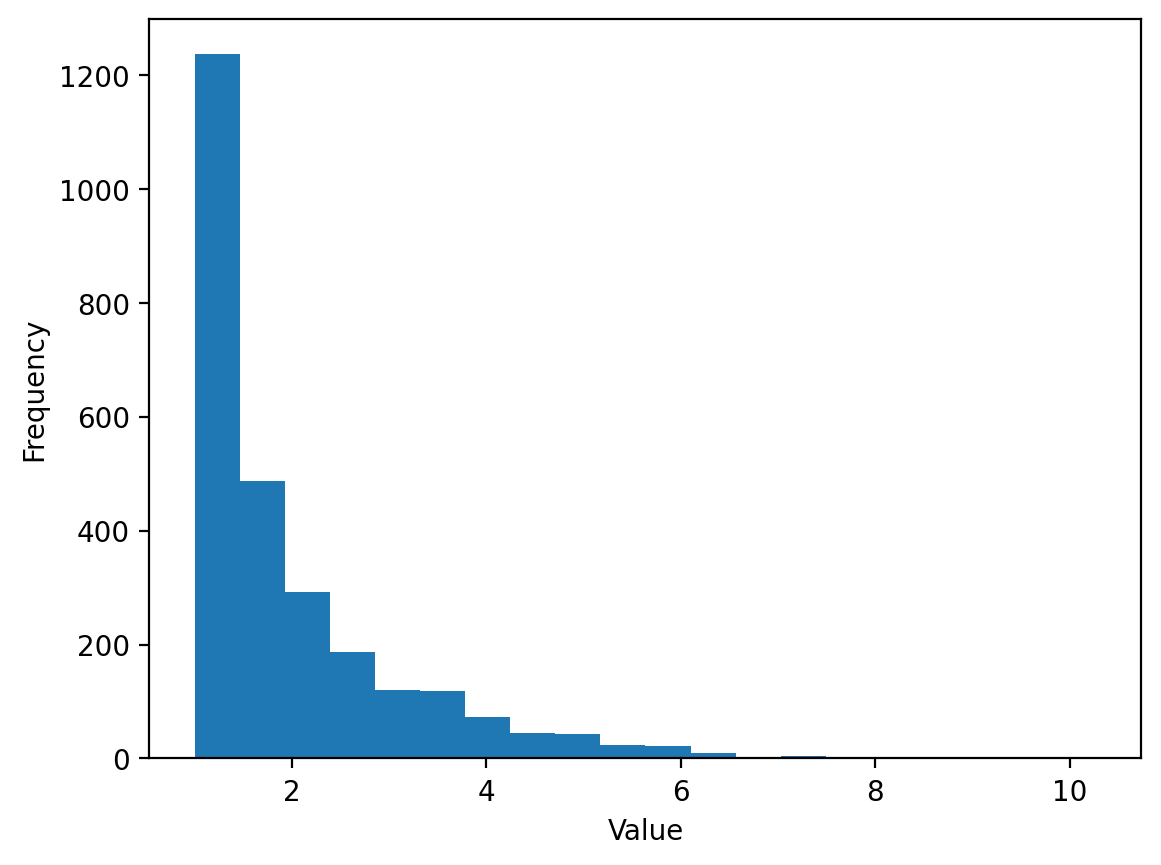

In [22]:
test.make_hist(test_abs_out, 20)

In [23]:
test.get_outlier_inds(test.abs_mat, 1)
col_outs = test.get_outlier_inds(test.abs_mat, 1)[2]

to get list of unique inds: set(inds_arr) 
get count of inds: Counter(inds_arr)
to get list of unique inds: set(inds_arr) 
get count of inds: Counter(inds_arr)


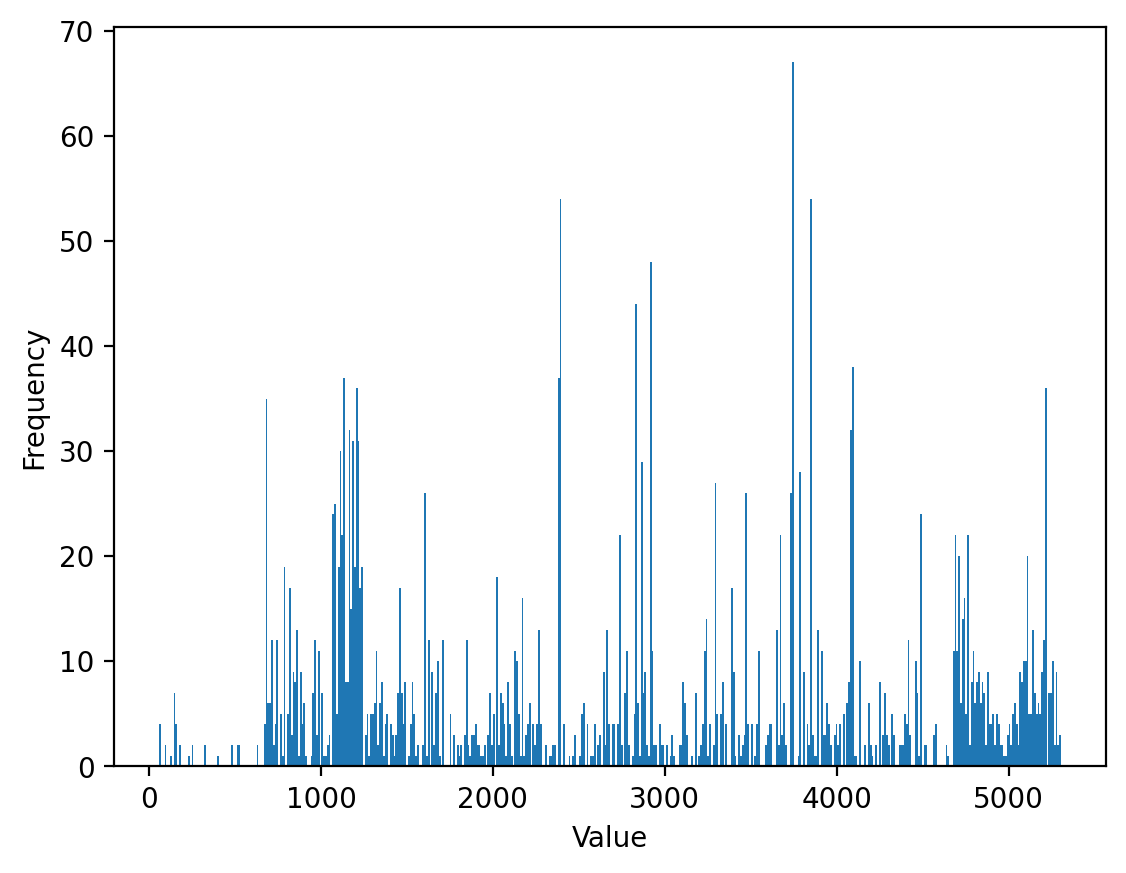

In [24]:
test.make_hist(col_outs, 500)

In [29]:
outlier_df = test.make_table(test.abs_mat, 1)
outlier_df

,track,bin,diff
0,CHIP:H3K27ac:OCI-LY3,44,1.039494
1,CHIP:H3K27ac:OCI-LY3,45,1.097754
2,CHIP:H3K27ac:OCI-LY3,46,1.058037
3,CHIP:H3K27ac:OCI-LY3,48,1.166883
4,CHIP:H3K27ac:OCI-LY3,53,1.050079
...,...,...,...
2664,CHIP:H3K4me1:CD14-positive monocyte male adult...,893,1.130640
2665,CHIP:H3K4me1:CD14-positive monocyte female,894,1.405522
2666,CHIP:H3K4me1:CD14-positive monocyte male adult...,894,1.274787
2667,CHIP:H3K4me1:CD14-positive monocyte female,895,1.697807


In [ ]:
    # def get_summary(self, arr):
    # def get_outliers(self, arr, tol):
    # def make_hist(arr, bin_num):
    # def get_outlier_inds(self, arr, tol):

In [30]:
test2 = My_class("AMIGO1", "1", rand_individual)

In [42]:
test2_abs_diff = test2.get_abs_diff()
test2_abs_diff, type(test2_abs_diff)

(array([[5.7518482e-06, 3.5203993e-06, 8.2701445e-07, ..., 6.4517371e-07,
         6.3516200e-07, 1.2149103e-06],
        [2.5629997e-06, 1.7061830e-06, 6.2957406e-06, ..., 3.6321580e-08,
         3.4179538e-06, 1.1073425e-06],
        [1.4603138e-06, 1.5571713e-06, 1.6354024e-06, ..., 1.9324943e-08,
         2.0535663e-06, 6.4587221e-07],
        ...,
        [5.5428594e-05, 6.6407025e-05, 5.4815784e-05, ..., 1.5444122e-05,
         2.6834011e-04, 1.5201420e-04],
        [9.3728304e-05, 1.3028085e-04, 1.2800470e-04, ..., 4.4204295e-05,
         4.0826201e-04, 2.2485107e-04],
        [3.8206577e-05, 5.6162477e-05, 9.3773007e-05, ..., 4.2296946e-05,
         5.4708123e-04, 2.2122264e-04]], dtype=float32),
 numpy.ndarray)

In [44]:
abs_diff2_sum = test2.get_summary(test2_abs_diff)
abs_diff2_sum


{'mean': 0.0008395509,
 'median': 0.00011945516,
 'std_dev': 0.009009555,
 'minimum': 0.0,
 'maximum': 2.1459656,
 'total_sum': 3996.6384,
 'q1': 2.8625130653381348e-05,
 'q2': 0.00011945515871047974,
 'q3': 0.0003998279571533203,
 'iqr': 0.00037120282649993896}

In [45]:
test2.get_summary(test2.abs_mat)

{'mean': 0.0008395509,
 'median': 0.00011945516,
 'std_dev': 0.009009555,
 'minimum': 0.0,
 'maximum': 2.1459656,
 'total_sum': 3996.6384,
 'q1': 2.8625130653381348e-05,
 'q2': 0.00011945515871047974,
 'q3': 0.0003998279571533203,
 'iqr': 0.00037120282649993896}

In [46]:
abs_outs2 = test2.get_outliers(test2.abs_mat, 1)
len(abs_outs2)

78

In [ ]:
test2.get_outlier_inds(test2.abs_mat)

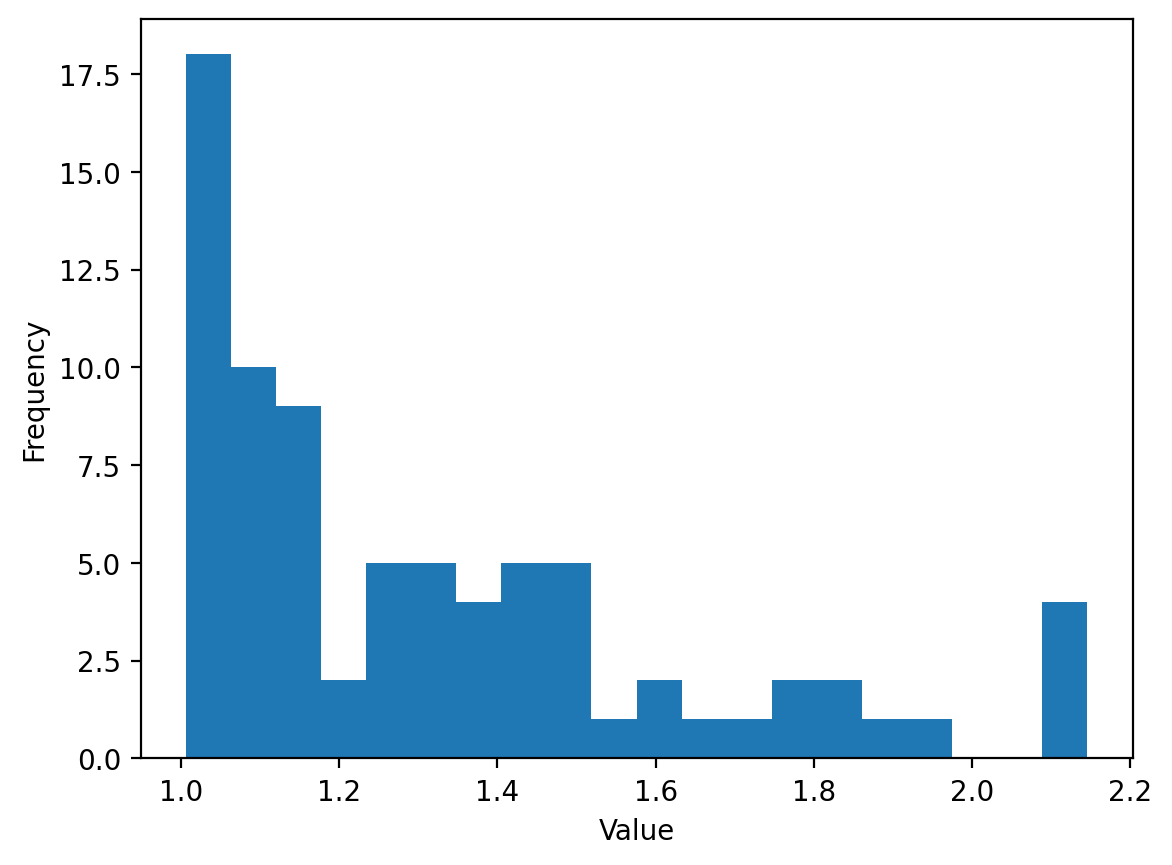

In [41]:
test2.make_hist(abs_outs2, 20)

In [107]:
gene = 'GSDMB'
gene_interval = gene_intervals[gene]
target_interval = kipoiseq.Interval("chr" + gene_interval[0],
                                        gene_interval[1],
                                        gene_interval[2])
target_fa = fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH))
window_coords = target_interval.resize(SEQUENCE_LENGTH)
cur_gene_vars = pd.read_csv("/grand/TFXcan/imlab/users/lvairus/hackenf/data/individual_beds/chr" + gene_interval[0] + "/chr" + gene_interval[0] + "_"+ gene + ".bed", sep="\t", header=0) # read in the appropriate bed file for the gene


In [108]:
haplo_1, haplo_2 = geno_to_seq(gene, rand_individual)

haplo_1_enc = one_hot_encode("".join(haplo_1))[np.newaxis]
haplo_2_enc = one_hot_encode("".join(haplo_2))[np.newaxis]
average_enc = np.add(haplo_1_enc, haplo_2_enc) / 2

In [109]:
prediction_1 = model.predict_on_batch(haplo_1_enc)['human'][0]
prediction_2 = model.predict_on_batch(haplo_2_enc)['human'][0]

post_average = (prediction_1 + prediction_2) / 2
pre_average = model.predict_on_batch(average_enc)['human'][0]

## Comparing Predictions

In [113]:
pre_average2, post_average2 = run_predictions2(gene, '17', rand_individual)

Currently on gene GSDMB, and predicting on individual NA12413...


In [110]:
diff = pre_average - post_average

abs_diff = np.sqrt(np.square(diff))

rel_diff = (abs_diff) / ((pre_average + post_average) + 10**-16)

In [111]:
# Summary Statistics of Absolute Differece
arr = abs_diff

print("Mean:", np.mean(arr))
print("Median:", np.median(arr))
print("Standard Deviation:", np.std(arr))
print("Minimum:", np.min(arr))
print("Maximum:", np.max(arr))
print("Sum:", np.sum(arr))

Mean: 0.011741725
Median: 0.0024814606
Standard Deviation: 0.06555718
Minimum: 0.0
Maximum: 10.2612915
Sum: 55895.87


In [91]:
# Summary Statistics of Relative Difference
arr = rel_diff

print("Mean:", np.mean(arr))
print("Median:", np.median(arr))
print("Standard Deviation:", np.std(arr))
print("Minimum:", np.min(arr))
print("Maximum:", np.max(arr))
print("Sum:", np.sum(arr))

Mean: 0.00026652514
Median: 8.4674466e-05
Standard Deviation: 0.0011749842
Minimum: 0.0
Maximum: 0.24099354
Sum: 1268.779


In [92]:
bigDiff = abs_diff[abs_diff>1]
len(bigDiff)

72

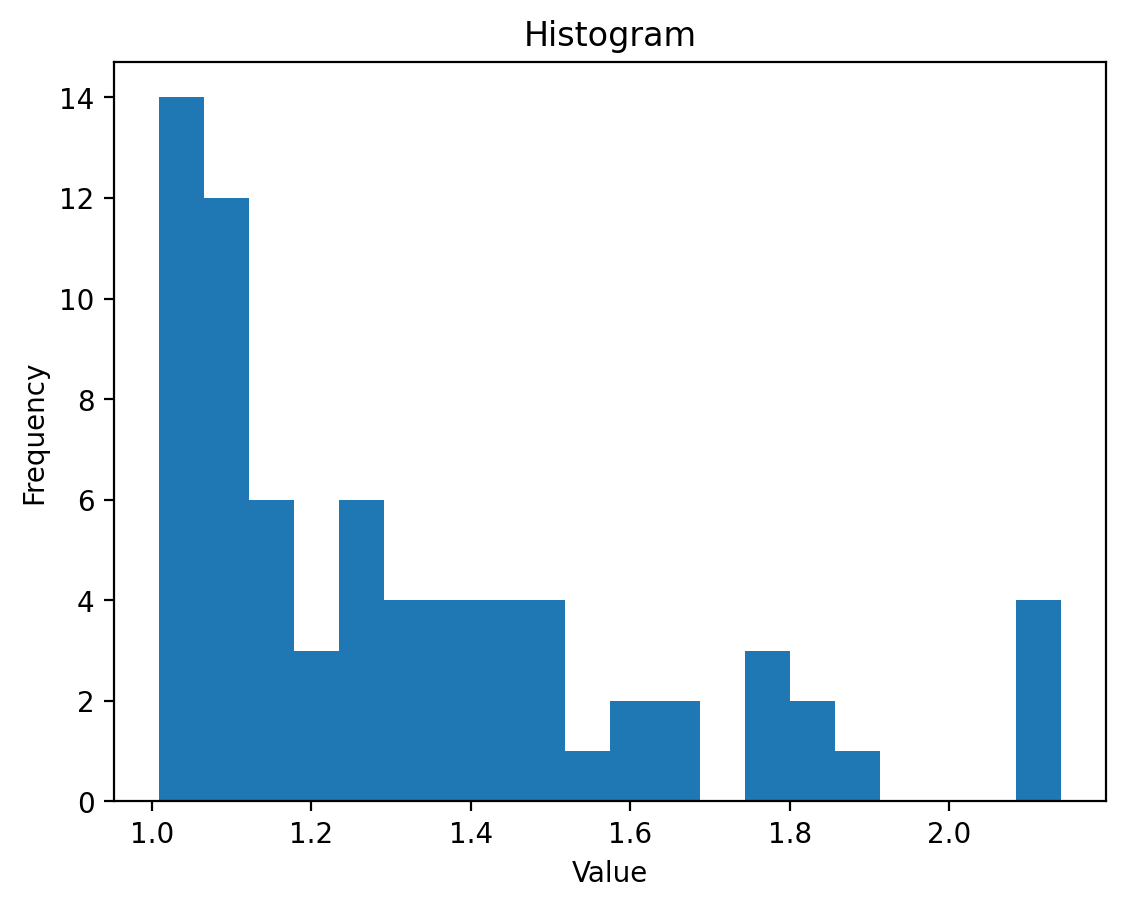

In [93]:
# Plot the histogram
plt.hist(bigDiff, bins=20)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Display the plot
plt.show()

## In which tracks is it not precise?

In [94]:
# max diff tolerance is 1. If a diff is greater than 1 we will count it as too big
tolerance = 1

indices = np.where(abs_diff > tolerance)
indices[0][0], indices[1][0]

ind_of_big_diffs = np.array(list(zip(indices[0], indices[1])))
len(ind_of_big_diffs), ind_of_big_diffs

(72,
 array([[ 773, 4740],
        [ 773, 4746],
        [ 773, 4747],
        [ 773, 4748],
        [ 773, 4754],
        [ 773, 4759],
        [ 773, 4760],
        [ 773, 4764],
        [ 773, 4766],
        [ 773, 4770],
        [ 773, 4777],
        [ 773, 4782],
        [ 773, 4797],
        [ 773, 4808],
        [ 773, 4810],
        [ 773, 4815],
        [ 773, 4816],
        [ 773, 4817],
        [ 773, 4818],
        [ 773, 4819],
        [ 773, 4868],
        [ 773, 4869],
        [ 773, 4870],
        [ 773, 4874],
        [ 773, 4877],
        [ 773, 4879],
        [ 773, 4881],
        [ 773, 4884],
        [ 773, 4885],
        [ 773, 4886],
        [ 773, 4887],
        [ 773, 4890],
        [ 773, 4892],
        [ 773, 4893],
        [ 773, 4897],
        [ 773, 4898],
        [ 773, 4900],
        [ 773, 4902],
        [ 773, 4905],
        [ 773, 4906],
        [ 773, 4909],
        [ 773, 4920],
        [ 773, 5056],
        [ 773, 5057],
        [ 773, 5072],
     

### cols

In [95]:
# all the indices of the columns where the diff exceeds tolerance
col_inds = indices[1]

In [96]:
counts = Counter(col_inds)
[(key,value) for key,value in counts.items() if value > 8]

[]

In [97]:
print(f"Number of unique col ind: {len(set(col_inds))} \nTotal col ind: {len(col_inds)}")

Number of unique col ind: 72 
Total col ind: 72


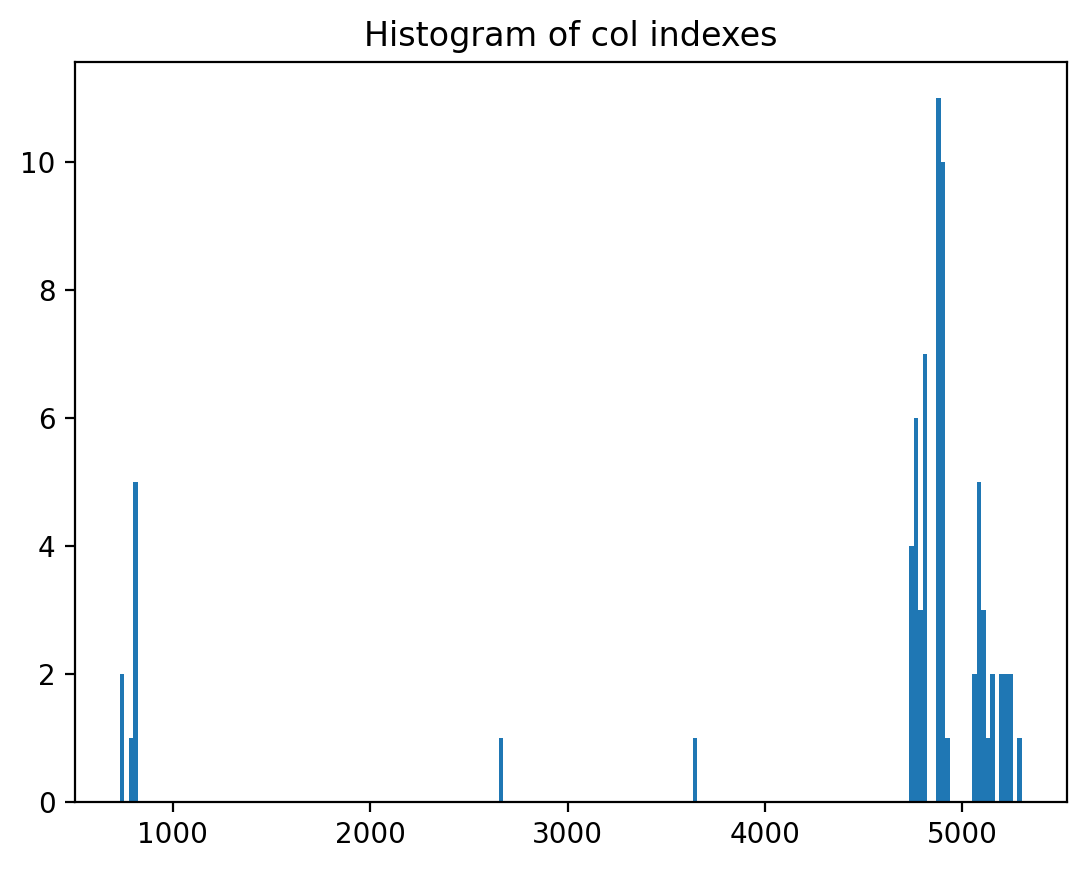

In [98]:
plt.hist(col_inds, bins=200)  # Specify the number of bins
plt.title('Histogram of col indexes')
plt.show()

Analysis: 
the difference exceeds the tolerance in 227 unique columns that are pretty evenly distributed, so enformer doesn't necessarily do better or worse with averaging before/after in any particular cell line

i want to get the amount of times it affects each col
227 uniqe cols

### rows

In [99]:
len(set(indices[0])), len(indices[0])

(3, 72)

In [100]:
# Summary Statistics of rows
arr1 = indices[0]

print("Mean:", np.mean(arr1))
print("Median:", np.median(arr1))
print("Standard Deviation:", np.std(arr1))
print("Minimum:", np.min(arr1))
print("Maximum:", np.max(arr1))
print("Sum:", np.sum(arr1))

q1 = np.percentile(arr, 25)
q3 = np.percentile(arr, 75)
iqr = q3 - q1

print("Q1:", q1)
print("Q3:", q3)
print("Interquartile Range:", iqr)

Mean: 780.9027777777778
Median: 773.0
Standard Deviation: 19.678075590631757
Minimum: 773
Maximum: 830
Sum: 56225


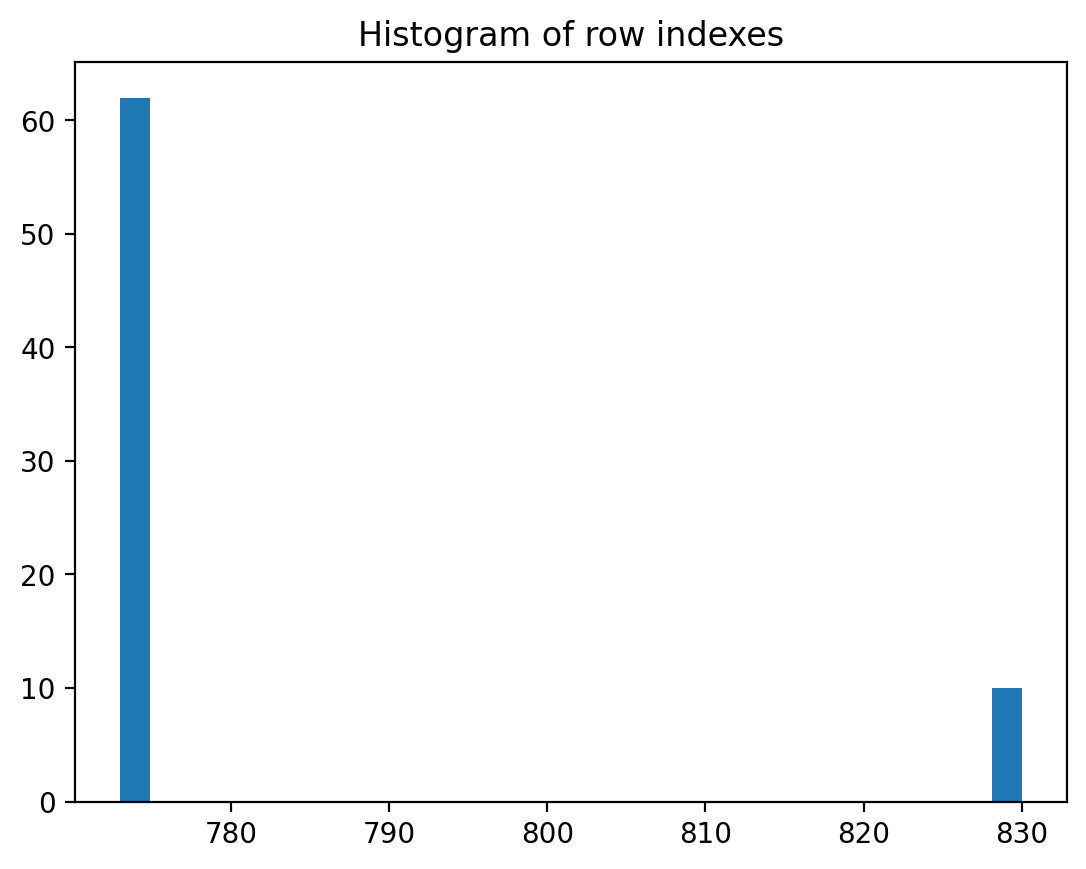

In [101]:
plt.hist(indices[0], bins=30)  # Specify the number of bins
plt.title('Histogram of row indexes')
plt.show()

Analysis:
There are only a few specific locations where enformer does worse 

## Comparing across tracks

In [102]:
res = []
for i in range(5313):
    pre_track = pre_average[:, i]
    post_track = post_average[:, i]
    corr = np.corrcoef(pre_track, post_track)[0][1]
    res.append(corr)


The results from both methods are nearly identical.

In [103]:
print(min(res), max(res))

0.9989958894392978 0.9999999912865261
